# Data Science Project 1 -  Improve the mass accuracy of spectra measured by Orbitrap mass spectrometers (orbitrap)

**Client:** Atmospheric Physical Chemistry group, INAR, University of Helsinki

**Description:** Motivation: When using a mass spectrometer, the measured mass usually shifts from its true mass. Hence, a mass calibration is an important procedure before allocating chemical formulae to the measured masses. A good mass calibration may greatly reduce the efforts of further analysis and increase the reliability of the results. Goals: Improve the mass calibration procedure for Orbitrap raw data, and perhaps for data measured by other mass spectrometers, e.g, TOF-MS Main tasks: 1) Test several fitting function for mass correction, and recommend one or a few that works best. 2) Test the performance of different parameters for mass correction, e.g., number of mass of the species for calibration.

**Data and tools:** Data: raw spectrum data measured by Orbitrap mass spectrometer. Tools: a) Orbitool, provided by the client. Orbitool will be used for reading the raw data and remove the noise, i.e., prepare the data for this analysis; b) Any programming language, which will be used to investigate this mass calibration problem.

## Environment

The environment should have the dependencies to run Orbitool and this notebook.

```bash
# Import environment
conda env create -f environment.yml

# Import kernel to jupyter
ipython kernel install --user --name=orbitool

# Export the environment to file
conda env export --no-builds > environment.yml
```

## Notebook practices

* Clean outputs before commiting!

## Dependencies

In [ ]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy.signal import find_peaks
from detecta import detect_peaks
from scipy.optimize import leastsq

## Data exploration

### Read the spectrum data

* Put the directory of spectrum CSV files to ```spectrum_data_directory``` variable.
    * If the begining of the CSV files contains some time information, then set ```contains_time_data``` variable to ```True```.
* Put the path of the peak list file to ```peak_list_file``` variable.
* If you just want to test the code, then you can speed up the code by setting the size of spectrum sample to ```random_sample_size``` variable.

In [ ]:
spectrum_data_directory = "data/CI-orbi_20201117165601 folder (first smal deviation file)/1 min"
contains_time_data = False #Spectrum files contains time data in forst 3 rows?
peak_list_file = "peak list/peaklist_1e5_background.csv"
random_sample_size = 5 #Take sample spectrums to speed up things. If 'None' then uses all the spectrums

spectrum_data_files = []
time_data = []
spectrums = []

# Get data files
for file in [f for f in listdir(spectrum_data_directory) if isfile(join(spectrum_data_directory, f))]:
    path_to_file = join(spectrum_data_directory, file)
    #print(path_to_file)
    if file.endswith(".csv"):
        spectrum_data_files.append(path_to_file)

# Take sample spectrums to speed up things
if random_sample_size:
    spectrum_data_files = random.sample(spectrum_data_files, min(random_sample_size, len(spectrum_data_files)))

# Read the spectrum files
for file in spectrum_data_files:
    if contains_time_data:
        time_data.append(pd.read_csv(file)[:2])
        spectrums.append(pd.read_csv(file, skiprows = 3).sort_values(by=['mz']))
    else:
        spectrums.append(pd.read_csv(file))

peak_list = dict(pd.read_csv(peak_list_file).values)

# Lookup
spectrums[0].head(5)

### Plot  the spectrums

* Plot all the spectrums with actual ions (from peak list file).

In [ ]:
%matplotlib notebook
# seaborn version should be at least 0.11!
print(sns.__version__)

# Concat files to same data frame with 'spectrum' separator column
tmp = pd.concat(spectrums, keys=range(len(spectrum_data_files)), names=["spectrum"])

# Plot the spectrums
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(data=tmp, ax=ax, x="mz", y="intensity", hue="spectrum", palette="tab10")
ax.legend([],[], frameon=False)
ax.ticklabel_format(useOffset=False)

# Plot the actual masses. Line height is taken from max intensity with +-eps interval.
eps = 0.0001
for formula, mz in peak_list.items():
    max_intensity = max([x for x in tmp.loc[(tmp["mz"] > mz - eps) & (tmp["mz"] < mz + eps)].intensity.values] + [0.0])
    plt.plot((mz,mz), (0.0,max_intensity), linestyle="--")

## Detect peaks

* Detect peaks
* Calculate/get some information about the peaks

In [ ]:
def find_peak_indices(data):
    '''
    Logic is same as in Koli's implementation. Tested that produces same results with spectrums in
    "data/CI-orbi_20201117165601 folder (first smal deviation file)/1 min" folder.
    '''
    peak_start_indices = [0] #Initialize with first start index
    peak_end_indices = []
    for i, row in data.iterrows():
        if i == 0:
            continue;
        if data.iloc[i]["intensity"] == 0.0 and data.iloc[i - 1]["intensity"] == 0.0:
            peak_start_indices.append(i)
            peak_end_indices.append(i - 1)
    peak_end_indices.append(len(data) - 1) #Finalize with last end index
    return np.column_stack((peak_start_indices, peak_end_indices))

peak_informations = []
for spectrum in spectrums:
    peak_information = []
    for start, end in find_peak_indices(spectrum):
        data = spectrum.iloc[start:(end+1)]
        max_intensity = data["intensity"].max()
        width = data["mz"].max() - data["mz"].min()
        average_mz = np.average(data["mz"], weights=data["intensity"])
        peak_information.append({
            "start": start,
            "end": end,
            "max_intensity": max_intensity,
            "average_mz": average_mz,
            "width": width
        })
    peak_informations.append(pd.DataFrame(peak_information))
  
peak_informations[0].head(5)

### Handle 'double peaks'

* Converts 'double peaks' to separate peaks.

In [ ]:
# TODO

## Fit Gaussian curve to peaks

* Fit Gaussian curve to peaks and get fitted means.
* Set the wanted resolution to ```resolution``` variable.

<IPython.core.display.Javascript object>


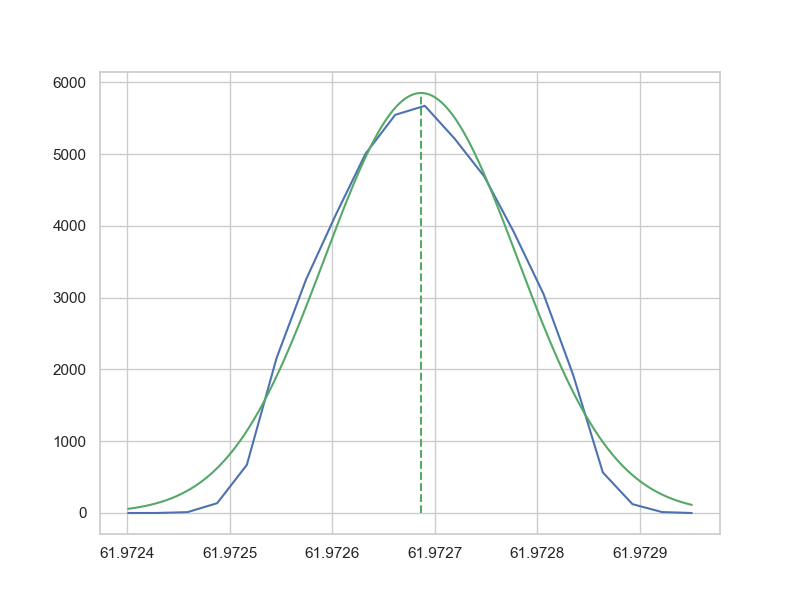

In [133]:
resolution = 280000

# x: data; a: height; x0: position; c: sigma or width
gauss  = lambda x, a, mu, sigma: a*np.exp(-(x-mu)**2/(2*sigma**2))

def fit_gaussian(peak, resolution=280000, show=False):
    '''
    returns: a: 'height'; mu: 'position'; sigma: 'width'
    '''
    mu = np.average(peak["mz"], weights=peak["intensity"])
    sigma = mu/(resolution*2*np.sqrt(2*np.log(2)))
    errfunc  = lambda p, x, y: (y - gauss(x, p[0], p[1], sigma))
    init  = [peak["intensity"].max(), mu]
    out = leastsq(errfunc, init, args=(peak["mz"], peak["intensity"]))
    c = out[0]
    if show:
        x = np.linspace(peak["mz"].min(), peak["mz"].max(), 1000)
        fig, ax = plt.subplots(figsize=(8,6))
        ax.ticklabel_format(useOffset=False)
        plt.plot(peak["mz"], peak["intensity"], "b")
        plt.plot(x, gauss(x, c[0], c[1], sigma), "g")
        plt.plot((c[1],c[1]), (0.0,c[0]), "g", linestyle="--")
    return c[0], c[1], sigma

# Test Fitting
n_spectrum = 0
n_peak = 1

spectrum = spectrums[n_spectrum]
peak_information = peak_informations[n_spectrum]
peak = peak_information.iloc[n_peak]
data = spectrum.iloc[int(peak["start"]):int(peak["end"] + 1)]
a, mu, sigma = fit_gaussian(data, resolution=resolution, show=True)

In [ ]:
# Add 'observed' column
for spectrum, peak_information in zip(spectrums, peak_informations):
    fitted_means = []
    for i, peak in peak_information.iterrows():
        data = spectrum.iloc[int(peak["start"]):int(peak["end"] + 1)]
        a, mu, sigma = fit_gaussian(data)
        fitted_means.append(mu)
    peak_information["observed"] = fitted_means
    
peak_informations[0].head(5)

## Classify ions

* Match ions to their peaks.

In [ ]:
# TODO

## Uncertainty of mass

* Analyse uncertainty of mass.

In [ ]:
# TODO